In [1]:
import math
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools
import datetime
from collections import defaultdict

df = pd.read_csv('D://Documenti//Università//Informatica Umanistica//DMII//occupancy_data//datatraining.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)

Utilizzo il codice datoci da Guidotti per l'hot encoding. In praticata trasforma le variabili categoriche per rendere più efficace la predizione. L'algoritmo, per come è scritto, contiene un errore: "join_axes" appartiene ad una versione di pandas precedente, ed è stato sostituito con ".reindex" o giù di lì.
Attualmente ho solo rimosso la parte che dava il problema, non sembrano esserci errori. Ma eventualmente tenere ciò in considerazione.

In [2]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

 Creo l'attributo "ore"

In [3]:
df['Ora'] = df['date']
for inx,item in enumerate(df['Ora']):
    df.at[inx+1,'Ora'] = df.at[inx+1,'Ora'].split(' ')[1]
    df.at[inx+1,'Ora'] = df.at[inx+1,'Ora'].split(':')[0]
    if int(df.at[inx+1,'Ora']) <= 6 :
        df.at[inx+1,'Ora'] = 'notte'
    elif int(df.at[inx+1,'Ora']) <= 12 :
        df.at[inx+1,'Ora'] = 'mattina'
    elif int(df.at[inx+1,'Ora']) <= 20 :
        df.at[inx+1,'Ora'] = 'pomeriggio'
    else : df.at[inx+1,'Ora'] = 'notte'
        
#Se volete la variabile Ora senza la suddivisione in "mattina" "pomeriggio" "sera" semplicemente cancellate dall' IF in
#poi.

Rimuovo date e HumidityRatio

In [4]:
class_name = 'Occupancy'
columns2remove = ['HumidityRatio','date']
df.drop(columns2remove, inplace=True, axis=1)
df.head()

,Temperature,Humidity,Light,CO2,Occupancy,Ora
1,23.18,27.2720,426.0,721.25,1,pomeriggio
2,23.15,27.2675,429.5,714.00,1,pomeriggio
3,23.15,27.2450,426.0,713.50,1,pomeriggio
4,23.15,27.2000,426.0,708.25,1,pomeriggio
5,23.10,27.2000,426.0,704.50,1,pomeriggio


Applico l'algoritmo di Guidotti sul dataset. Si può osservare come i valori di "Ora" siano stati trasformati in attributi binari dove 1 significa "Sì" e 0 significa "No".

In [5]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,Ora=mattina,Ora=notte,Ora=pomeriggio,Occupancy
1,23.18,27.2720,426.0,721.25,0,0,1,1
2,23.15,27.2675,429.5,714.00,0,0,1,1
3,23.15,27.2450,426.0,713.50,0,0,1,1
4,23.15,27.2000,426.0,708.25,0,0,1,1
5,23.10,27.2000,426.0,704.50,0,0,1,1


Leggo il file "datatest2" per la validazione.

In [6]:
dfVal = pd.read_csv('D://Documenti//Università//Informatica Umanistica//DMII//occupancy_data//datatest2.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)

Apporto al datatest2 le medesime modifiche apportate al training (NON SONO SCIURO DI QUESTO PASSAGGIO)

In [7]:
dfVal['Ora'] = dfVal['date']
for inx,item in enumerate(dfVal['Ora']):
    dfVal.at[inx+1,'Ora'] = dfVal.at[inx+1,'Ora'].split(' ')[1]
    dfVal.at[inx+1,'Ora'] = dfVal.at[inx+1,'Ora'].split(':')[0]
    if int(dfVal.at[inx+1,'Ora']) <= 6 :
        dfVal.at[inx+1,'Ora'] = 'notte'
    elif int(dfVal.at[inx+1,'Ora']) <= 12 :
        dfVal.at[inx+1,'Ora'] = 'mattina'
    elif int(dfVal.at[inx+1,'Ora']) <= 20 :
        dfVal.at[inx+1,'Ora'] = 'pomeriggio'
    else : dfVal.at[inx+1,'Ora'] = 'notte'

In [8]:
dfVal.drop(columns2remove, inplace=True, axis=1)

In [9]:
res1 = prepare_dataset(dfVal, class_name)
dfVal, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res1
dfVal.head()

,Temperature,Humidity,Light,CO2,Ora=mattina,Ora=notte,Ora=pomeriggio,Occupancy
1,21.7600,31.133333,437.333333,1029.666667,0,0,1,1
2,21.7900,31.000000,437.333333,1000.000000,0,0,1,1
3,21.7675,31.122500,434.000000,1003.750000,0,0,1,1
4,21.7675,31.122500,439.000000,1009.500000,0,0,1,1
5,21.7900,31.133333,437.333333,1005.666667,0,0,1,1


Unisco i due dataset

In [10]:
df_conc=pd.concat([df,dfVal])

# Splitting

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
attributes = [col for col in df_conc.columns if col != class_name]
X = df_conc[attributes].values
y = df_conc[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# k Nearest Neighbor

In [17]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

Studio l'algoritmo sul training. Uso come valore iniziale di N la radice quadrata del numero di record del training.
Uso peso uniforme e distanza euclidea.

In [14]:
df_conc.shape

(17895, 8)

In [15]:
import math
math.sqrt(17895)

133.77219442021575

###### Peso uniforme e distanza euclidea

In [16]:
clf = KNeighborsClassifier(n_neighbors=134, weights='uniform', )
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=134, p=2,
                     weights='uniform')

Lo applico sul dataset di validazione.

In [17]:
y_pred = clf.predict(X_test)

In [18]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9927360774818402
F1-score [0.99537969 0.98302133]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4235
           1       0.97      1.00      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



###### Peso uniforme e distanza manhattan

In [19]:
clf = KNeighborsClassifier(n_neighbors=134, weights='uniform', p=1)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=134, p=1,
                     weights='uniform')

In [20]:
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9927360774818402
F1-score [0.99537969 0.98302133]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4235
           1       0.97      1.00      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



###### Peso non uniforme e distanza euclidea

In [21]:
clf = KNeighborsClassifier(n_neighbors=134, weights='distance')
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=134, p=2,
                     weights='distance')

In [22]:
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9925498230582976
F1-score [0.99526066 0.98259356]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4235
           1       0.97      1.00      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



###### Peso non uniforme e distanza manhattan

In [23]:
clf = KNeighborsClassifier(n_neighbors=134, weights='distance', p=1)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=134, p=1,
                     weights='distance')

In [24]:
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9923635686347551
F1-score [0.99514276 0.98215063]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4235
           1       0.97      0.99      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



###### Peso uniforme, disanza euclidea n = 250

Provo ad aumentare n

In [25]:
clf = KNeighborsClassifier(n_neighbors=250, weights='uniform', )
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=250, p=2,
                     weights='uniform')

In [26]:
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9888247345874465
F1-score [0.99287242 0.97413793]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4235
           1       0.95      1.00      0.97      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.98      5369
weighted avg       0.99      0.99      0.99      5369



###### Peso uniforme, distanza euclidea, n=10

In [37]:
clf = KNeighborsClassifier(n_neighbors=10, weights='uniform', )
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [38]:
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9921773142112125
F1-score [0.99502605 0.98169137]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4235
           1       0.97      0.99      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



###### Peso uniforme, distanza manhattan, n=50

In [29]:
clf = KNeighborsClassifier(n_neighbors=50, weights='uniform', p=2 )
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [30]:
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9925498230582976
F1-score [0.99525954 0.9826087 ]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4235
           1       0.97      1.00      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



###### Peso uniforme, distanza manhattan, n= 250

In [35]:
clf = KNeighborsClassifier(n_neighbors=250, weights='uniform', p=2 )
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=250, p=2,
                     weights='uniform')

In [36]:
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9888247345874465
F1-score [0.99287242 0.97413793]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4235
           1       0.95      1.00      0.97      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.98      5369
weighted avg       0.99      0.99      0.99      5369



Osserviamo che, in linea di massima, otteniamo risultati migliori con la manhattan e i valori di accuracy e F1 si tengono uniforme con n= 10-200 circa, e scendono aumentando o diminuendo.

In [40]:
clf = KNeighborsClassifier(n_neighbors=500, weights='distance', p=2 )
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=500, p=2,
                     weights='distance')

In [41]:
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9916185509405848
F1-score [0.99466509 0.98046027]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4235
           1       0.97      1.00      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



Tuttavia con la distanza pesata, i valori di accuracy e F1 si alzano fino a n= 500. Tuttavia l'incremento è solo dello 0.001 su tutti i valori, quindi - non riuscendomelo a spiegare - tenderei a non tenerlo in considerazione.
I valori che risultano migliori sono quindi: n=130, distanza uniforme, metrica manhattan.

# Cross Validation

In [18]:
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import ShuffleSplit

clf = KNeighborsClassifier()
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(clf, X, y, cv=cv)

print('Accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Accuracy 0.989 +/- 0.001


## GridSearch

In [19]:
from sklearn.model_selection import RandomizedSearchCV
param_list = {'n_neighbors': [1, 10, 50, 133, 250, 500],
              'p': [1, 2],
             }

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=20, cv=5)
random_search.fit(X_train, y_train)
clf = random_search.best_estimator_


y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:277: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy 0.9901285155522443
F1-score [0.9937404  0.97666226]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4235
           1       0.98      0.98      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



In [23]:
random_search.cv_results_['params'][random_search.cv_results_['rank_test_score'][0]]

{'p': 2, 'n_neighbors': 1}

# Computazione finale


In [56]:
clf = KNeighborsClassifier(n_neighbors=130, weights='uniform', p=1 )
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=130, p=1,
                     weights='uniform')

In [57]:
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9927360774818402
F1-score [0.99537969 0.98302133]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4235
           1       0.97      1.00      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



In [58]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

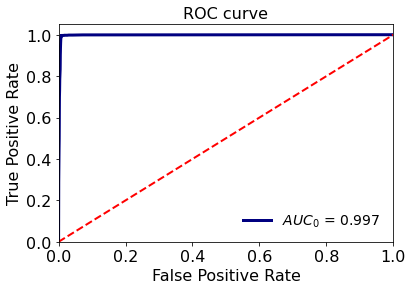

In [59]:
plt.plot(fpr0, tpr0, color='navy', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [60]:
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_lift_curve

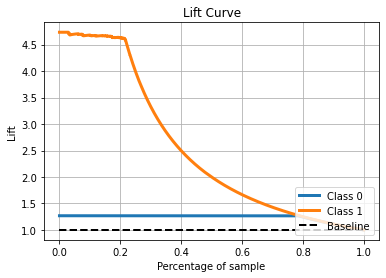

In [61]:
plot_lift_curve(y_test, y_score)
plt.show()

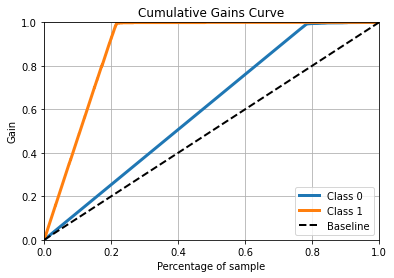

In [62]:
from scikitplot.metrics import plot_cumulative_gain

plot_cumulative_gain(y_test, y_score)
plt.show()